# Sonecule TVOSon Time-variant Oscillators Sonification

Using a bank of oscillators to represent the channels of multivariate data:

- mapping each value to a displacement of the pitch
  - ampmode=="val"/"absval": mapping each value or absolute value to amplitude
  - ampmode=="change": mapping the absolute change to amplitude
- parameters:
  - base_pitch: midi note number of the first channel
  - delta_pitch: 
    - if int: channel separation in semitones
    - if array: offsets in 
  

## Data Preparation

In [3]:
import sonecules as sn
sn.startup()
sn.pb = sn.playback
ctx = sn.gcc()
import sc3nb as scn
from pya import Asig
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,3)
%matplotlib widget

<IPython.core.display.Javascript object>

SC already started
sclang already started
scsynth already started


In [4]:
%run prepare-data.ipynb

Asig('_arrayindexed_arrayindexed'): 6 x 200 @ 50Hz = 4.000s cn=['0', '1', '2', '5', '9', '12']

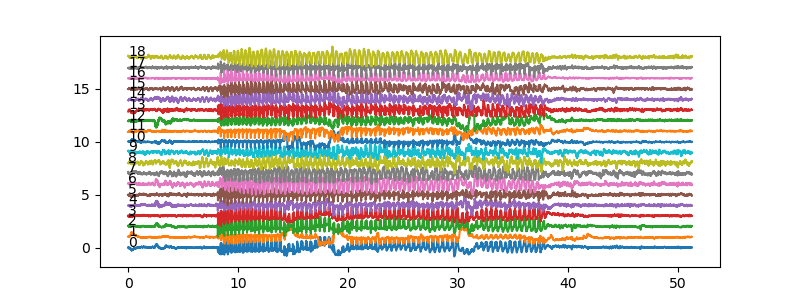

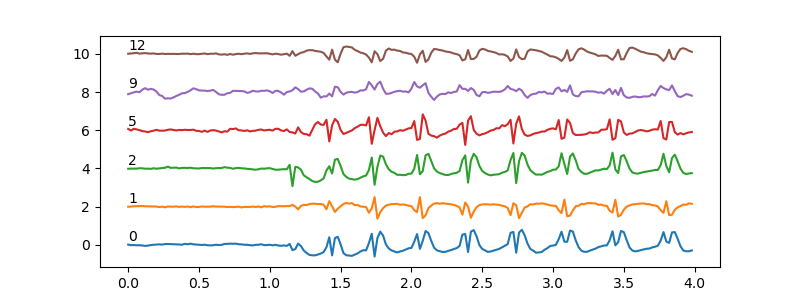

In [6]:

# select test data for sonecule
dasig = Asig(eeg_data, sr=250)
plt.figure(); dasig.plot(offset=1)

data = dasig[{7:11}, [0,1,2,5,9,12]][::5]
plt.figure(); data.plot(offset=2)

## Sonecule pre-development

In [ ]:
# create synth for tvosc
scn.SynthDef("tvosc-sine-1ch", 
"""{ | out=0, freq=400, amp=0.1, pan=0, lg=0.1 | 
    var sig = SinOsc.ar(freq.lag(lg), mul: amp.lag(lg));
    Out.ar(out, Pan2.ar(sig, pan));
}""").add();

In [ ]:
# set mesonic backend latency
sn.pb().processor.latency = 0.1

In [ ]:
# create synths
syns = []
for i in range(data.channels):
    syns.append(ctx.synths.create(name="tvosc-sine-1ch", track=i,  mutable=True))
syns

ctx.reset()

# here schedule function, with argument for replace default to true
rate = 0.5
maxonset = -1
base_pitch = 50
delta_pitch = 7
ampmode = "absval" # "change"

# start syns (oscillators)
with ctx.at(time=0):
    for i, syn in enumerate(syns):
        syn.start(freq=300+40*i, amp=0.01, pan=0, lg=0.1)
data.samples, data.get_duration(), data.sr

# modulate oscillators
for i, r in enumerate(data.sig):
    onset = i / data.sr / rate
    change = r - data.sig[max(0, i-1)]
    with ctx.at(time=onset):
        for i, el in enumerate(r):
            cp = base_pitch + i * delta_pitch 
            syns[i].freq = scn.midicps(cp + scn.linlin(el, -1, 1, -0.5*delta_pitch, + 0.5*delta_pitch))
            if ampmode == "change":
                syns[i].amp = scn.linlin(abs(change[i]), 0, 0.8, 0, 0.1)
            elif ampmode == "absamp":
                syns[i].amp = scn.linlin(abs(el), 0, 0.8, 0, 0.1)
    if onset > maxonset:
        maxonset = onset

# stop oscillators
with ctx.at(time=maxonset):
    for syn in syns:
        syn.stop()

# plot timeline and start sonification playback
ctx.timeline.plot()
sn.pb().start()

## Implementation

In [7]:
from mesonic.synth import Synth
from sonecules.base import Sonecule
import numpy, numbers

In [9]:
class TVOSon(Sonecule):
    def __init__(self, data, context=None):
        super().__init__(context=context)

        self.data = data
        ctx = self.context

        # create SynthDef for tvosc
        scn.SynthDef(
            "tvosc-sine-1ch",
            """{ | out=0, freq=400, amp=0.1, pan=0, lg=0.1 | 
            var sig = SinOsc.ar(freq.lag(lg), mul: amp.lag(lg));
            Out.ar(out, Pan2.ar(sig, pan));
        }""",
        ).add()

        ctx._backend.sc.server.sync()

        # create synths
        self.syns = []
        for i in range(data.channels):
            syn = ctx.synths.create(name="tvosc-sine-1ch", track=i, mutable=True)
            self.syns.append(syn)

    def schedule(
        self,
        at=0,
        rate=0.5,
        base_pitch=50,
        pitch_step=7,
        pitch_relwid=0.5,
        amp_mode="absval",
        map_mode="channelwise",
        level=-6,
        reset_flag=True,
    ):
        # here schedule function, with argument for replace default to true
        # "change"
        ctx = self.context
        if reset_flag:
            sn.reset() 

        # start syns (oscillators)
        with ctx.at(time=at):
            for i, syn in enumerate(self.syns):
                syn.start(freq=440, amp=0.1, pan=0, lg=0.1)

        # compute parameters for mapping
        # 1. src ranges for pitch mapping
        if map_mode == "channelwise":
            channel_mins = self.data.sig.min(axis=0)
            channel_maxs = self.data.sig.max(axis=0)
        else:
            channel_mins = numpy.ones(data.channels) * self.data.sig.min(axis=0)
            channel_maxs = numpy.ones(data.channels) * self.data.sig.max(axis=0)

        if isinstance(pitch_step, numbers.Number):
            pch_centers = [0] * data.channels
            pch_wids = [0] * data.channels
            for i in range(self.data.channels):
                pch_centers[i] = base_pitch + i * pitch_step 
                pch_wids[i] = pitch_step * pitch_relwid / 2
        elif isinstance(pitch_step, list):
            print(len(pitch_step), self.data.channels)
            assert len(pitch_step) == self.data.channels
            pch_centers = numpy.array(pitch_step) + base_pitch
            pch_wids = numpy.diff([0] + pitch_step) * pitch_relwid 

        global_amp = scn.dbamp(level)
        maxonset = -1
        # modulate oscillators
        for j, r in enumerate(self.data.sig):
            onset = j / self.data.sr / rate
            change = r - self.data.sig[max(0, j - 1)]
            with ctx.at(time=at + onset):
                for i, el in enumerate(r):
                    cp = pch_centers[i]
                    dp = pch_wids[i]
                    pitch = scn.linlin(
                        el, channel_mins[i], channel_maxs[i], cp - dp, cp + dp
                    )
                    self.syns[i].freq = scn.midicps(pitch)
                    if amp_mode == "change":
                        self.syns[i].amp = scn.linlin(
                            abs(change[i]), 0, 0.8, 0, global_amp
                        )
                    elif amp_mode == "absval":
                        srcmax = max(abs(channel_mins[i]), abs(channel_maxs[i]))
                        self.syns[i].amp = scn.linlin(abs(el), 0, srcmax, 0, global_amp)
                    elif amp_mode == "value":
                        self.syns[i].amp = scn.linlin(
                            abs(el), channel_mins[i], channel_maxs[i], 0, global_amp
                        )
            if onset > maxonset:
                maxonset = onset

        # stop oscillators
        with ctx.at(time=at + maxonset):
            for syn in self.syns:
                syn.stop()
        return self
    
    def start(self, **kwargs):
        """start sonification rendering by starting the playback
        kwargs are passed on to start(), so use rate to control speedup, etc.
        """
        print(kwargs)
        sn.playback().start(**kwargs)
    

## Usage / Demo Snippets

In [11]:
snctvo = TVOSon(dasig[{7.5: 11.5}, [1, 2, 3]][::2])
snctvo.schedule(
    at=0,
    rate=2,
    base_pitch=60,
    pitch_step=12,
    pitch_relwid=0.1,
    amp_mode="change",
    level=-20,
    map_mode="channelwise",
).start(rate=1)

{'rate': 1}


In [12]:
snctvo = TVOSon(dasig[{7.5: 11.5}, [0,1,2,3,4,5]][::2])
snctvo.schedule(at=0, rate=0.5,
    base_pitch=60,
    pitch_step=[0,3,7,10,15,19],
    pitch_relwid=0.5,
    amp_mode="change",
    level=-10,
    map_mode="channelwise",
).start(rate=1)

6 6
{'rate': 1}


In [17]:
# timbral sonification is just a special case of TVOSon
snctvo = TVOSon(dasig[{7.5: 11.5}, :][::2])
f0 = 60
base_pitch = scn.cpsmidi(f0)
pitch_steps = [ scn.cpsmidi(f0*(i+1)) - base_pitch for i in range(dasig.channels)] 
snctvo.schedule(at=0, rate=0.3,
    base_pitch=base_pitch,
    pitch_step=pitch_steps,
    pitch_relwid=0,  # use 1.5 for pitch added effect
    amp_mode="change",
    level=-10,
    map_mode="channelwise",
).start(rate=1)

19 19
{'rate': 1}


In [13]:
# ctx.backend.stop(ctx)